## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [20]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [21]:
# importing environment
from TCGame_Env import TicTacToe
env = TicTacToe()

In [22]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [23]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [24]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [25]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # print(epsilon)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else:
        possible_action = [i for i in env.action_space(state)[0]]        
        action = possible_action[np.random.choice(range(len(possible_action)))]    #Exploration: randomly choosing and action
    
    return action


#### Tracking the state-action pairs for checking convergence - write your code here

In [26]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [27]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2)),
                       ('x-x-x-x-x-x-x-x-x',(7,5)), ('x-x-x-x-x-x-x-x-x',(8,2)),
                       ('x-x-x-x-x-x-x-x-x',(8,3)), ('x-x-x-x-x-x-x-x-x',(7,9))]    #selected >4 values to try different results in the end
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []
  

In [28]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [29]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [30]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [31]:
EPISODES = 200000
LR = 0.01                   # learning rate
GAMMA = 0.9                # discount factor

max_epsilon = 1.0
min_epsilon = 0.000001
decay_rate = 0.001        # epsilon decay rate
threshold = 200       # no of episodes after which states_tracked wwill be saved
policy_threshold = 300   # no of episodes after which Q dictionary/table will be saved

### Q-update loop ---write your code here

In [32]:
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe() # call the environment
    curr_state = env.state    
    done = False  
    add_to_dict(curr_state)  # adding the current state to dictionary

    while done != True:  
        curr_state1 = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)   # applying epislon method
        next_state, reward, done = env.step(curr_state, curr_action) # getting rewar
        next_state_temp = Q_state(next_state)
        add_to_dict(next_state)
        
        # Updating rules
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state1][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next])))
                                                      - Q_dict[curr_state1][curr_action] ) 
        else:
            Q_dict[curr_state1][curr_action] += LR * ((reward - Q_dict[curr_state1][curr_action]))

        # navigating to next state
        curr_state = next_state
        
     #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')
#         print(episode) 

    if ((episode+1)% policy_threshold) == 0:
        save_obj(Q_dict,'Policy_Q_dict')  
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

#### Check the Q-dictionary

In [33]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.8193042011833173,
              (0, 3): -0.8190383359296988,
              (0, 5): -0.8181511468671464,
              (0, 7): -0.8397909244031602,
              (0, 9): -0.8176316745946616,
              (1, 1): -0.8178369231029342,
              (1, 3): -0.8176877352693882,
              (1, 5): -0.8190415374172423,
              (1, 7): -0.8187635544448526,
              (1, 9): -0.821414362776258,
              (2, 1): -0.819119382092414,
              (2, 3): -0.8182007414075175,
              (2, 5): -0.8205416250330114,
              (2, 7): -0.8899084658156087,
              (2, 9): -0.8244168483499428,
              (3, 1): -0.8176057519755301,
              (3, 3): -0.8183903791309639,
              (3, 5): -0.8178292279185303,
              (3, 7): -0.9570817927235745,
              (3, 9): -0.8179675326608691,
              (4, 1): -0.8182775175230829,
              (4, 3): -0.8184318088221281,
              (4,

In [34]:
len(Q_dict)

53220

In [35]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

<function matplotlib.pyplot.show(close=None, block=None)>

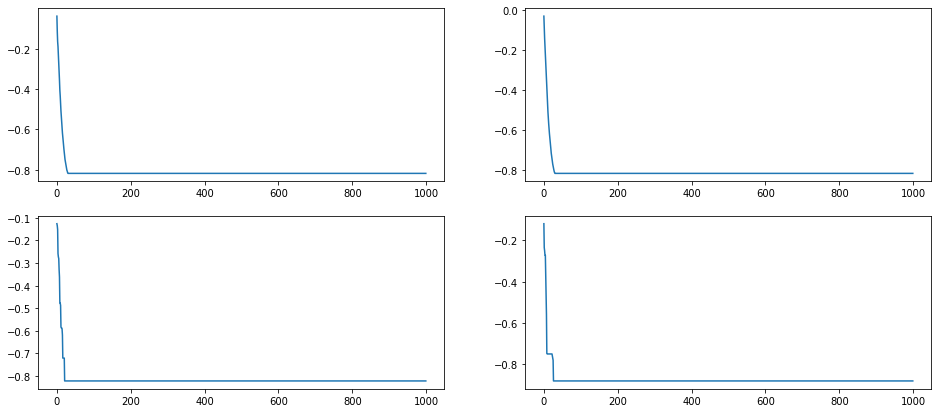

In [36]:
# Write the code for plotting the graphs for state-action pairs tracked

plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(6,5)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(6,5)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(8,3)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(8,3)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(1,9)]))
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(7,9)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-x-x-x-x-x'][(7,9)]))
plt.show

### Epsilon - decay check

In [37]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

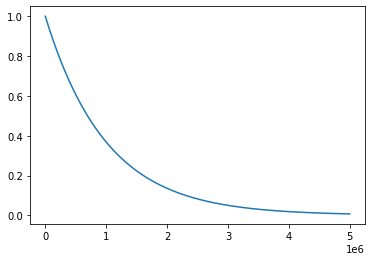

In [38]:
plt.plot(time, epsilon)
plt.show()